In [3]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#First I chose the 2nd dataset and downloaded the tar file after which I unzipped it and placed it in the location
train_dir = r'C:\Users\DELL\Downloads\20news-bydate\20news-bydate-train'
test_dir = r'C:\Users\DELL\Downloads\20news-bydate\20news-bydate-test'

#This function helps to load the data properly as the data is in the format of multiple directories
def load_data_from_directory(data_dir):
    texts, labels = [], []
    for label, category in enumerate(os.listdir(data_dir)):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                with open(file_path, 'r', encoding='latin1') as file:
                    texts.append(file.read())
                    labels.append(label)
    return texts, labels

#I am loading the data for the training and testingg
train_texts, train_labels = load_data_from_directory(train_dir)
test_texts, test_labels = load_data_from_directory(test_dir)

#Now as per the problem statement converting the text to word of bags
vectorizer = CountVectorizer(max_features=50000)  #Limit to 50,000 most frequent terms
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)
y_train, y_test = train_labels, test_labels

#Created a function to implement Naive Bayes
def train_naive_bayes_sparse(X, y, alpha=1.0):
    n_classes = np.unique(y)
    n_words = X.shape[1]
    class_priors = np.zeros(len(n_classes))
    word_probs = np.zeros((len(n_classes), n_words))

    for c in n_classes:
        class_mask = np.array(y) == c
        X_c = X[class_mask]  #Filter samples for class c
        class_priors[c] = X_c.shape[0] / X.shape[0] 
        word_count = X_c.sum(axis=0) + alpha  #I have now added smoothing
        word_probs[c] = word_count / word_count.sum()  #Now to normalize the data

    return class_priors, word_probs

def predict_naive_bayes_sparse(X, class_priors, word_probs):
    log_priors = np.log(class_priors)
    log_probs = np.log(word_probs + 1e-10)  
    log_posteriors = X @ log_probs.T + log_priors  #Now do the Sparse matrix multiplication
    return np.argmax(log_posteriors, axis=1)

#Now to train Naive Bayes
class_priors, word_probs = train_naive_bayes_sparse(X_train, y_train)

#For the prediction of Naive Bayes
y_pred_nb = predict_naive_bayes_sparse(X_test, class_priors, word_probs)

#Now to train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
lr_model.fit(X_train, y_train)

#Now to predict Logistic Regression
y_pred_lr = lr_model.predict(X_test)

#Finally to Evaluate Naive Bayes
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)

#To evaluate Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)

#Finally to print results
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


Naive Bayes Accuracy: 0.7959373340414233
Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       319
           1       0.61      0.81      0.69       389
           2       0.20      0.00      0.01       394
           3       0.54      0.78      0.64       392
           4       0.78      0.83      0.80       385
           5       0.75      0.79      0.77       395
           6       0.87      0.77      0.82       390
           7       0.86      0.93      0.89       396
           8       0.94      0.94      0.94       398
           9       0.95      0.91      0.93       397
          10       0.95      0.96      0.96       399
          11       0.83      0.92      0.87       396
          12       0.77      0.73      0.75       393
          13       0.90      0.83      0.86       396
          14       0.86      0.90      0.88       394
          15       0.81      0.95      0.87       398
          16       0

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

In [2]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Define paths to training and testing directories
train_dir = r'C:\Users\DELL\Downloads\20news-bydate\20news-bydate-train'
test_dir = r'C:\Users\DELL\Downloads\20news-bydate\20news-bydate-test'

#This is the helper function to load data from directories
def load_data_from_directory(data_dir):
    texts, labels = [], []
    for label, category in enumerate(os.listdir(data_dir)):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                with open(file_path, 'r', encoding='latin1') as file:
                    texts.append(file.read())
                    labels.append(label)
    return texts, labels

#Now to load data
train_texts, train_labels = load_data_from_directory(train_dir)
test_texts, test_labels = load_data_from_directory(test_dir)

#I am using the TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

#Now perfroming the Dimensionality Reduction using Truncated SVD
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

#FInally the Naive Bayes Functions
def train_naive_bayes_sparse(X, y, alpha=1.0):
    n_classes = np.unique(y)
    n_words = X.shape[1]
    class_priors = np.zeros(len(n_classes))
    word_probs = np.zeros((len(n_classes), n_words))

    for c in n_classes:
        class_mask = np.array(y) == c
        X_c = X[class_mask]  #Filter samples for class c
        class_priors[c] = X_c.shape[0] / X.shape[0]  
        word_count = X_c.sum(axis=0) + alpha  #Now to add the smoothing
        word_probs[c] = word_count / word_count.sum()  #Now to Normalize data

    return class_priors, word_probs

def predict_naive_bayes_sparse(X, class_priors, word_probs):
    log_priors = np.log(class_priors)
    log_probs = np.log(word_probs + 1e-10)  
    log_posteriors = X @ log_probs.T + log_priors  #Now to perfrom Sparse matrix multiplication
    return np.argmax(log_posteriors, axis=1)

#Now to Train Naive Bayes
class_priors, word_probs = train_naive_bayes_sparse(X_train_tfidf, train_labels, alpha=0.5)
y_pred_nb = predict_naive_bayes_sparse(X_test_tfidf, class_priors, word_probs)

#Finally to Evaluate Naive Bayes
nb_accuracy = accuracy_score(test_labels, y_pred_nb)
print(f"Improved Naive Bayes Accuracy: {nb_accuracy}")
print("Improved Naive Bayes Report:")
print(classification_report(test_labels, y_pred_nb))

#To Train Logistic Regression
lr_model = LogisticRegression(max_iter=5000, solver='saga', n_jobs=-1)
lr_model.fit(X_train_reduced, train_labels)
y_pred_lr = lr_model.predict(X_test_reduced)

#To Evaluate Logistic Regression
lr_accuracy = accuracy_score(test_labels, y_pred_lr)
print(f"Improved Logistic Regression Accuracy: {lr_accuracy}")
print("Improved Logistic Regression Report:")
print(classification_report(test_labels, y_pred_lr))


Improved Naive Bayes Accuracy: 0.8167817312798725
Improved Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       319
           1       0.75      0.75      0.75       389
           2       0.80      0.68      0.74       394
           3       0.65      0.79      0.71       392
           4       0.85      0.83      0.84       385
           5       0.87      0.79      0.83       395
           6       0.88      0.80      0.84       390
           7       0.86      0.91      0.88       396
           8       0.93      0.94      0.93       398
           9       0.92      0.92      0.92       397
          10       0.93      0.97      0.95       399
          11       0.82      0.94      0.88       396
          12       0.80      0.70      0.74       393
          13       0.91      0.81      0.85       396
          14       0.86      0.91      0.89       394
          15       0.60      0.96      0.74       398
  

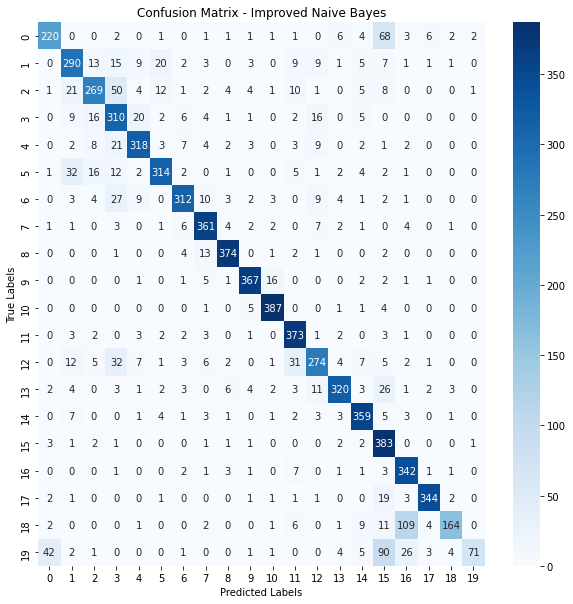

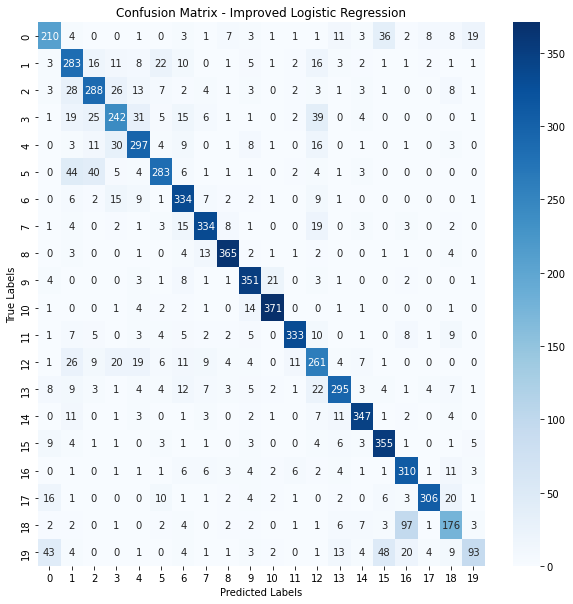

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot confusion matrix for Naive Bayes
plot_confusion_matrix(test_labels, y_pred_nb, "Confusion Matrix - Improved Naive Bayes")

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(test_labels, y_pred_lr, "Confusion Matrix - Improved Logistic Regression")


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

#Now load the dataset
file_path = r'C:\Users\DELL\customer_purchase_dataset_multiclass.csv'
data = pd.read_csv(file_path)

#Now we separate features and target
X = data.drop(columns=['Purchase_Category'])
y = data['Purchase_Category']

#Now convert target to numerical
binary_y = np.where(y == 0, -1, 1)  #We are using for AdaBoost, use -1 and 1

#Now Split the data(80 and 20)
X_train, X_test, y_train, y_test = train_test_split(X, binary_y, test_size=0.2, random_state=42)

#Now the function to calculate entropy
def entropy(y):
    unique_classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

#Now the function to calculate Information Gain
def information_gain(X, y, feature_index, threshold):
    parent_entropy = entropy(y)
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
        return 0

    n = len(y)
    n_left, n_right = np.sum(left_indices), np.sum(right_indices)
    entropy_left = entropy(y[left_indices])
    entropy_right = entropy(y[right_indices])
    child_entropy = (n_left / n) * entropy_left + (n_right / n) * entropy_right

    return parent_entropy - child_entropy

#Now the function to find the best split
def best_split(X, y):
    best_feature, best_threshold, best_gain = -1, None, -float('inf')
    n_features = X.shape[1]
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold, best_gain

#Now Decision Tree Node Class
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

#Now the Adjusted build_tree for binary targets
def build_tree_adjusted(X, y, max_depth, min_samples_split, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))
    if (depth >= max_depth or n_samples < min_samples_split or n_labels == 1):
        most_common_label = np.bincount(y.astype(int)).argmax()
        return DecisionTreeNode(value=most_common_label)

    feature, threshold, gain = best_split(X, y)
    if gain == 0:
        most_common_label = np.bincount(y.astype(int)).argmax()
        return DecisionTreeNode(value=most_common_label)

    left_indices = X[:, feature] <= threshold
    right_indices = X[:, feature] > threshold
    left_subtree = build_tree_adjusted(X[left_indices], y[left_indices], max_depth, min_samples_split, depth + 1)
    right_subtree = build_tree_adjusted(X[right_indices], y[right_indices], max_depth, min_samples_split, depth + 1)

    return DecisionTreeNode(feature, threshold, left_subtree, right_subtree)

#Finally Predict function for a single tree
def predict_tree(node, sample):
    if node.value is not None:
        return node.value
    if sample[node.feature] <= node.threshold:
        return predict_tree(node.left, sample)
    else:
        return predict_tree(node.right, sample)

#The Random Forest Class
class RandomForest:
    def __init__(self, n_trees=10, max_depth=3, min_samples_split=10, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.max_features = self.max_features or int(np.sqrt(n_features))
        for _ in range(self.n_trees):
            X_sample, y_sample = resample(X, y, n_samples=n_samples, replace=True, random_state=_)
            feature_indices = np.random.choice(n_features, self.max_features, replace=False)
            tree = build_tree_adjusted(X_sample[:, feature_indices], y_sample, self.max_depth, self.min_samples_split)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_preds = np.zeros((X.shape[0], self.n_trees))
        for i, (tree, feature_indices) in enumerate(self.trees):
            tree_preds[:, i] = [predict_tree(tree, sample[feature_indices]) for sample in X]
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=tree_preds)
        return majority_votes

#The AdaBoost Class
class AdaBoost:
    def __init__(self, n_estimators=10, max_depth=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=sample_weights)
            X_sample, y_sample = X[sample_indices], y[sample_indices]
            tree = build_tree_adjusted(X_sample, y_sample, max_depth=self.max_depth, min_samples_split=2)
            y_pred = np.array([predict_tree(tree, sample) for sample in X])
            incorrect = y_pred != y
            err = np.sum(sample_weights[incorrect]) / np.sum(sample_weights)
            if err > 0.5:
                continue
            elif err == 0:
                alpha = 1
            else:
                alpha = 0.5 * np.log((1 - err) / max(err, 1e-10))
            self.models.append((tree, alpha))
            sample_weights[incorrect] *= np.exp(alpha)
            sample_weights[~incorrect] *= np.exp(-alpha)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for tree, alpha in self.models:
            predictions = np.array([predict_tree(tree, sample) for sample in X])
            final_predictions += alpha * predictions
        return np.sign(final_predictions).astype(int)

#Now we will Convert binary labels for evaluation
binary_y_train_adjusted = np.where(y_train == -1, 0, 1)
binary_y_test_adjusted = np.where(y_test == -1, 0, 1)

#Now to Train and evaluate Decision Tree
tree = build_tree_adjusted(X_train.values, binary_y_train_adjusted, max_depth=3, min_samples_split=10)
tree_preds = [predict_tree(tree, sample) for sample in X_test.values]

#Now Train and evaluate Random Forest
rf = RandomForest(n_trees=10, max_depth=5, min_samples_split=10, max_features=3)
rf.fit(X_train.values, binary_y_train_adjusted)
rf_preds = rf.predict(X_test.values)

#Now Train and evaluate AdaBoost
adaboost = AdaBoost(n_estimators=10, max_depth=1)
adaboost.fit(X_train.values, binary_y_train_adjusted)
ada_preds = adaboost.predict(X_test.values)

#Now Evaluate models
models = {
    "Single Decision Tree": [tree_preds],
    "Random Forest": [rf_preds],
    "AdaBoost": [ada_preds],
}

print("Model Performance Metrics:")
for model_name, predictions in models.items():
    preds = predictions[0]
    accuracy = accuracy_score(binary_y_test_adjusted, preds)
    precision = precision_score(binary_y_test_adjusted, preds, average='weighted', zero_division=0)
    recall = recall_score(binary_y_test_adjusted, preds, average='weighted')
    f1 = f1_score(binary_y_test_adjusted, preds, average='weighted')
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")


Model Performance Metrics:

Single Decision Tree:
Accuracy: 59.00%
Precision: 55.42%
Recall: 59.00%
F1 Score: 45.50%

Random Forest:
Accuracy: 59.00%
Precision: 55.36%
Recall: 59.00%
F1 Score: 44.67%

AdaBoost:
Accuracy: 59.00%
Precision: 34.81%
Recall: 59.00%
F1 Score: 43.79%


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

# Load dataset
file_path = r'C:\Users\DELL\customer_purchase_dataset_multiclass.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['Purchase_Category'])
y = data['Purchase_Category']

# Convert target to non-negative integers
binary_y = np.where(y == 0, 0, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, binary_y, test_size=0.2, random_state=42)

# Entropy and Information Gain functions
def entropy(y):
    unique_classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def information_gain(X, y, feature_index, threshold):
    parent_entropy = entropy(y)
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
        return 0

    n = len(y)
    n_left, n_right = np.sum(left_indices), np.sum(right_indices)
    entropy_left = entropy(y[left_indices])
    entropy_right = entropy(y[right_indices])
    child_entropy = (n_left / n) * entropy_left + (n_right / n) * entropy_right

    return parent_entropy - child_entropy

def best_split(X, y):
    best_feature, best_threshold, best_gain = -1, None, -float('inf')
    n_features = X.shape[1]
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold, best_gain

# Decision Tree Node
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Decision Tree construction
def build_tree(X, y, max_depth, min_samples_split, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))
    if (depth >= max_depth or n_samples < min_samples_split or n_labels == 1):
        most_common_label = np.bincount(y).argmax()
        return DecisionTreeNode(value=most_common_label)

    feature, threshold, gain = best_split(X, y)
    if gain == 0:
        most_common_label = np.bincount(y).argmax()
        return DecisionTreeNode(value=most_common_label)

    left_indices = X[:, feature] <= threshold
    right_indices = X[:, feature] > threshold
    left_subtree = build_tree(X[left_indices], y[left_indices], max_depth, min_samples_split, depth + 1)
    right_subtree = build_tree(X[right_indices], y[right_indices], max_depth, min_samples_split, depth + 1)

    return DecisionTreeNode(feature, threshold, left_subtree, right_subtree)

# Predict using tree
def predict_tree(node, sample):
    if node.value is not None:
        return node.value
    if sample[node.feature] <= node.threshold:
        return predict_tree(node.left, sample)
    else:
        return predict_tree(node.right, sample)

# Random Forest class
class RandomForest:
    def __init__(self, n_trees=10, max_depth=3, min_samples_split=10, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.max_features = self.max_features or int(np.sqrt(n_features))
        for _ in range(self.n_trees):
            X_sample, y_sample = resample(X, y, n_samples=n_samples, replace=True, random_state=_)
            feature_indices = np.random.choice(n_features, self.max_features, replace=False)
            tree = build_tree(X_sample[:, feature_indices], y_sample, self.max_depth, self.min_samples_split)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_preds = np.zeros((X.shape[0], self.n_trees))
        for i, (tree, feature_indices) in enumerate(self.trees):
            tree_preds[:, i] = [predict_tree(tree, sample[feature_indices]) for sample in X]
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=tree_preds)
        return majority_votes

# AdaBoost class
class AdaBoost:
    def __init__(self, n_estimators=10, max_depth=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=sample_weights)
            X_sample, y_sample = X[sample_indices], y[sample_indices]
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth, min_samples_split=2)
            y_pred = np.array([predict_tree(tree, sample) for sample in X])
            incorrect = y_pred != y
            err = np.sum(sample_weights[incorrect]) / np.sum(sample_weights)
            if err > 0.5:
                continue
            elif err == 0:
                alpha = 1
            else:
                alpha = 0.5 * np.log((1 - err) / max(err, 1e-10))
            self.models.append((tree, alpha))
            sample_weights[incorrect] *= np.exp(alpha)
            sample_weights[~incorrect] *= np.exp(-alpha)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for tree, alpha in self.models:
            predictions = np.array([predict_tree(tree, sample) for sample in X])
            final_predictions += alpha * predictions
        return np.sign(final_predictions).astype(int)

# Reduced feature set based on importance
selected_features = ['Age', 'Annual_Income']
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

# Add engineered features using .loc
X_train_selected.loc[:, 'Income_Spending_Interaction'] = X_train['Annual_Income'] * X_train['Spending_Score']
X_test_selected.loc[:, 'Income_Spending_Interaction'] = X_test['Annual_Income'] * X_test['Spending_Score']

# Train and evaluate models
rf = RandomForest(n_trees=10, max_depth=3, max_features=2)
rf.fit(X_train_selected.values, y_train)
rf_preds = rf.predict(X_test_selected.values)

adaboost = AdaBoost(n_estimators=10, max_depth=1)
adaboost.fit(X_train_selected.values, y_train)
ada_preds = adaboost.predict(X_test_selected.values)

# Evaluate metrics
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.2%}")
print(f"Precision: {precision_score(y_test, rf_preds, average='weighted', zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, rf_preds, average='weighted'):.2%}")
print(f"F1 Score: {f1_score(y_test, rf_preds, average='weighted'):.2%}")

print("\nAdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, ada_preds):.2%}")
print(f"Precision: {precision_score(y_test, ada_preds, average='weighted', zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, ada_preds, average='weighted'):.2%}")
print(f"F1 Score: {f1_score(y_test, ada_preds, average='weighted'):.2%}")



Random Forest Performance:
Accuracy: 59.50%
Precision: 75.98%
Recall: 59.50%
F1 Score: 44.91%

AdaBoost Performance:
Accuracy: 59.00%
Precision: 34.81%
Recall: 59.00%
F1 Score: 43.79%
